# Simulation result analysis for cost valley weights study

## Section I, trajectory analysis

In [14]:
from Config import Config
from usr_func.checkfolder import checkfolder
import numpy as np
import matplotlib.pyplot as plt
import os 
from tqdm import tqdm
from matplotlib.gridspec import GridSpec

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20

filepath = "./npy/CV/Myopic/"
print(os.listdir(filepath))

c = Config()
plg_b = c.get_polygon_border()
plg_o = c.get_polygon_obstacle()

os.system("ls -lh " + filepath)

['P_small_grf', 'IBV.npy', 'P_large_grf', 'VR.npy', 'TRAJ.npy', 'P_order_old', 'RMSE.npy']
total 112
-rw-r--r--  1 yaolin  staff   9.5K Dec 30 15:02 IBV.npy
drwxr-xr-x  6 yaolin  staff   192B Dec 30 12:51 P_large_grf
drwxr-xr-x  6 yaolin  staff   192B Dec 21 11:46 P_order_old
drwxr-xr-x  6 yaolin  staff   192B Dec 23 21:41 P_small_grf
-rw-r--r--  1 yaolin  staff   9.5K Dec 30 15:02 RMSE.npy
-rw-r--r--  1 yaolin  staff    19K Dec 30 15:02 TRAJ.npy
-rw-r--r--  1 yaolin  staff   9.5K Dec 30 15:02 VR.npy


0

In [15]:
figpath = "./../../fig/Sim_2DNidelva/Cases/Myopic/"
d_traj = np.load(filepath + "TRAJ.npy")
d_ibv = np.load(filepath + "IBV.npy")
d_vr = np.load(filepath + "VR.npy")
d_rmse = np.load(filepath + "RMSE.npy")
print(os.listdir(figpath))

['Pmyopic', 'P_009.png', 'P_008.png', 'P_large_grf', 'P_myopic', 'P_003.png', 'P_002.png', 'P_000.png', 'P_001.png', 'P_005.png', 'P_004.png', 'P_006.png', 'P_007.png']


In [7]:
d_traj.shape

(3, 3, 5, 2)

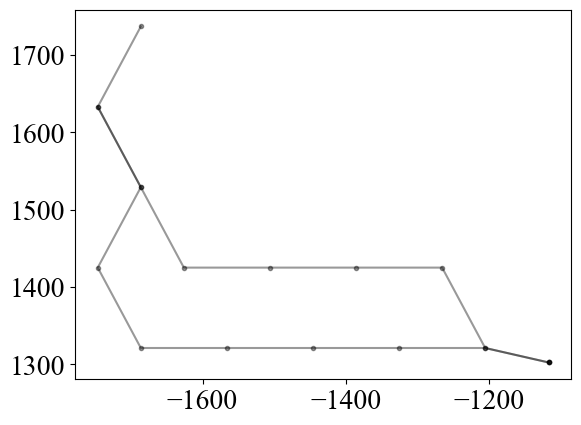

In [6]:
plt.plot(d_traj[0, 0, :10, 1], d_traj[0, 0, :10, 0], 'k.-', alpha=.4)
plt.plot(d_traj[4, 0, :10, 1], d_traj[4, 0, :10, 0], 'k.-', alpha=.4)

In [16]:
def plotf(i, title):
    fig = plt.figure(figsize=(40, 12))
    gs = GridSpec(nrows=1, ncols=3)
    
    def plot_subplot(data, title):
        for j in range(data.shape[0]):
            plt.plot(data[j, :i, 1], data[j, :i, 0], 'k.-', alpha=.4)
            ax.plot(plg_b[:, 1], plg_b[:, 0], 'r-.')
            ax.plot(plg_o[:, 1], plg_o[:, 0], 'r-.')
            ax.set_xlabel("East")
            ax.set_ylabel("North")
            ax.set_title(title)
            ax.set_aspect("equal")
        
    ax = fig.add_subplot(gs[0])
    plot_subplot(d_traj[:, 0, :, :], "EIBV dominant")
    
    ax = fig.add_subplot(gs[1])
    plot_subplot(d_traj[:, 2, :, :], "Equal weights")
    
    ax = fig.add_subplot(gs[2])
    plot_subplot(d_traj[:, 1, :, :], "IVR dominant")

    plt.savefig(figpath + "P_{:03d}.png".format(i))
    plt.close("all")

for i in tqdm(range(d_traj.shape[2])):
    plotf(i, "Trajectory after " + str(i) + " iterations. ")



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:25<00:00,  3.13it/s]


In [ ]:
pb = c.get_polygon_border()
po = c.get_polygon_obstacle()

In [ ]:
s1 = np.load(filepath + "eibv_ivr_1.90_0.10.npy")
s2 = np.load(filepath + "eibv_ivr_0.10_1.90.npy")
s3 = np.load(filepath + "eibv_ivr_1.00_1.00.npy")

def plotf(s, i): 
    plt.plot(pb[:, 1], pb[:, 0], 'r-.')
    plt.plot(po[:, 1], po[:, 0], 'r-.')
    for j in range(s.shape[0]):
        plt.plot(s[j, :i, 1], s[j, :i, 0], 'k.-', alpha=.1)
    plt.gca().set_aspect('equal')
    plt.xlabel("East")
    plt.ylabel("North")
#     plt.title("Iteration: " + str(i))

for i in tqdm(range(s1.shape[1])):

    fig = plt.figure(figsize=(30, 10))
    gs = GridSpec(nrows=1, ncols=3)
    ax = fig.add_subplot(gs[0])
    plotf(s1, i)
    ax.set_title("EIBV: {:.2f}, IVR: {:.2f}".format(1.9, .1))

    ax = fig.add_subplot(gs[1])
    plotf(s2, i)
    ax.set_title("EIBV: {:.2f}, IVR: {:.2f}".format(.1, 1.9))

    ax = fig.add_subplot(gs[2])
    plotf(s3, i)
    ax.set_title("EIBV: {:.2f}, IVR: {:.2f}".format(1., 1.))

    plt.savefig(figpath + "P_{:03d}.png".format(i))
    plt.close("all")
#     plt.show()
#     if i == 2: 
#         break

## Section II, metric analysis

In [12]:
d_ibv.shape

(50, 3, 81)

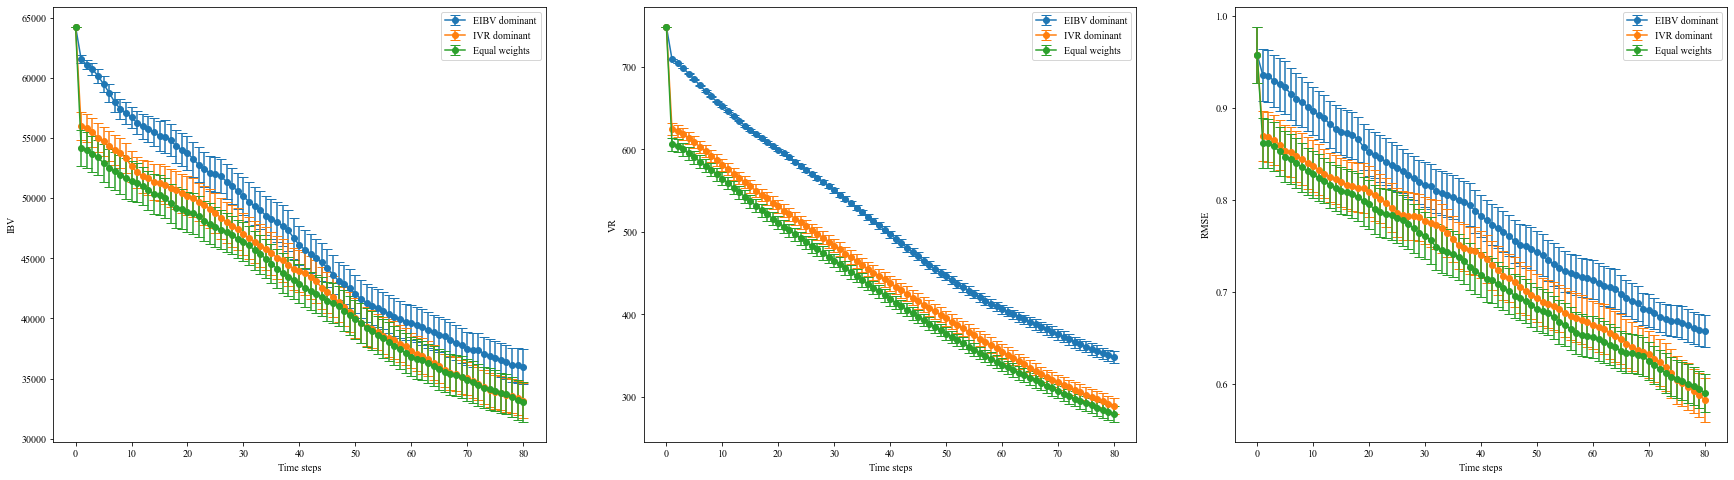

In [5]:
fig = plt.figure(figsize=(30, 8))
gs = GridSpec(nrows=1, ncols=3)

def plotf_sim(data, ylabel="IBV", counter=0):
    N = data.shape[0]
    hx = np.arange(data.shape[-1])

    ax = fig.add_subplot(gs[counter])
    ax.errorbar(hx, y=np.mean(data[:, 0, :], axis=0), yerr=np.std(data[:, 0, :], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                         label="EIBV dominant")
    ax.errorbar(hx, y=np.mean(data[:, 2, :], axis=0), yerr=np.std(data[:, 2, :], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                         label="IVR dominant")
    ax.errorbar(hx, y=np.mean(data[:, 1, :], axis=0), yerr=np.std(data[:, 1, :], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                         label="Equal weights")
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel(ylabel)

plotf_sim(d_ibv, "IBV", 0)
plotf_sim(d_vr, "VR", 1)
plotf_sim(d_rmse, "RMSE", 2)


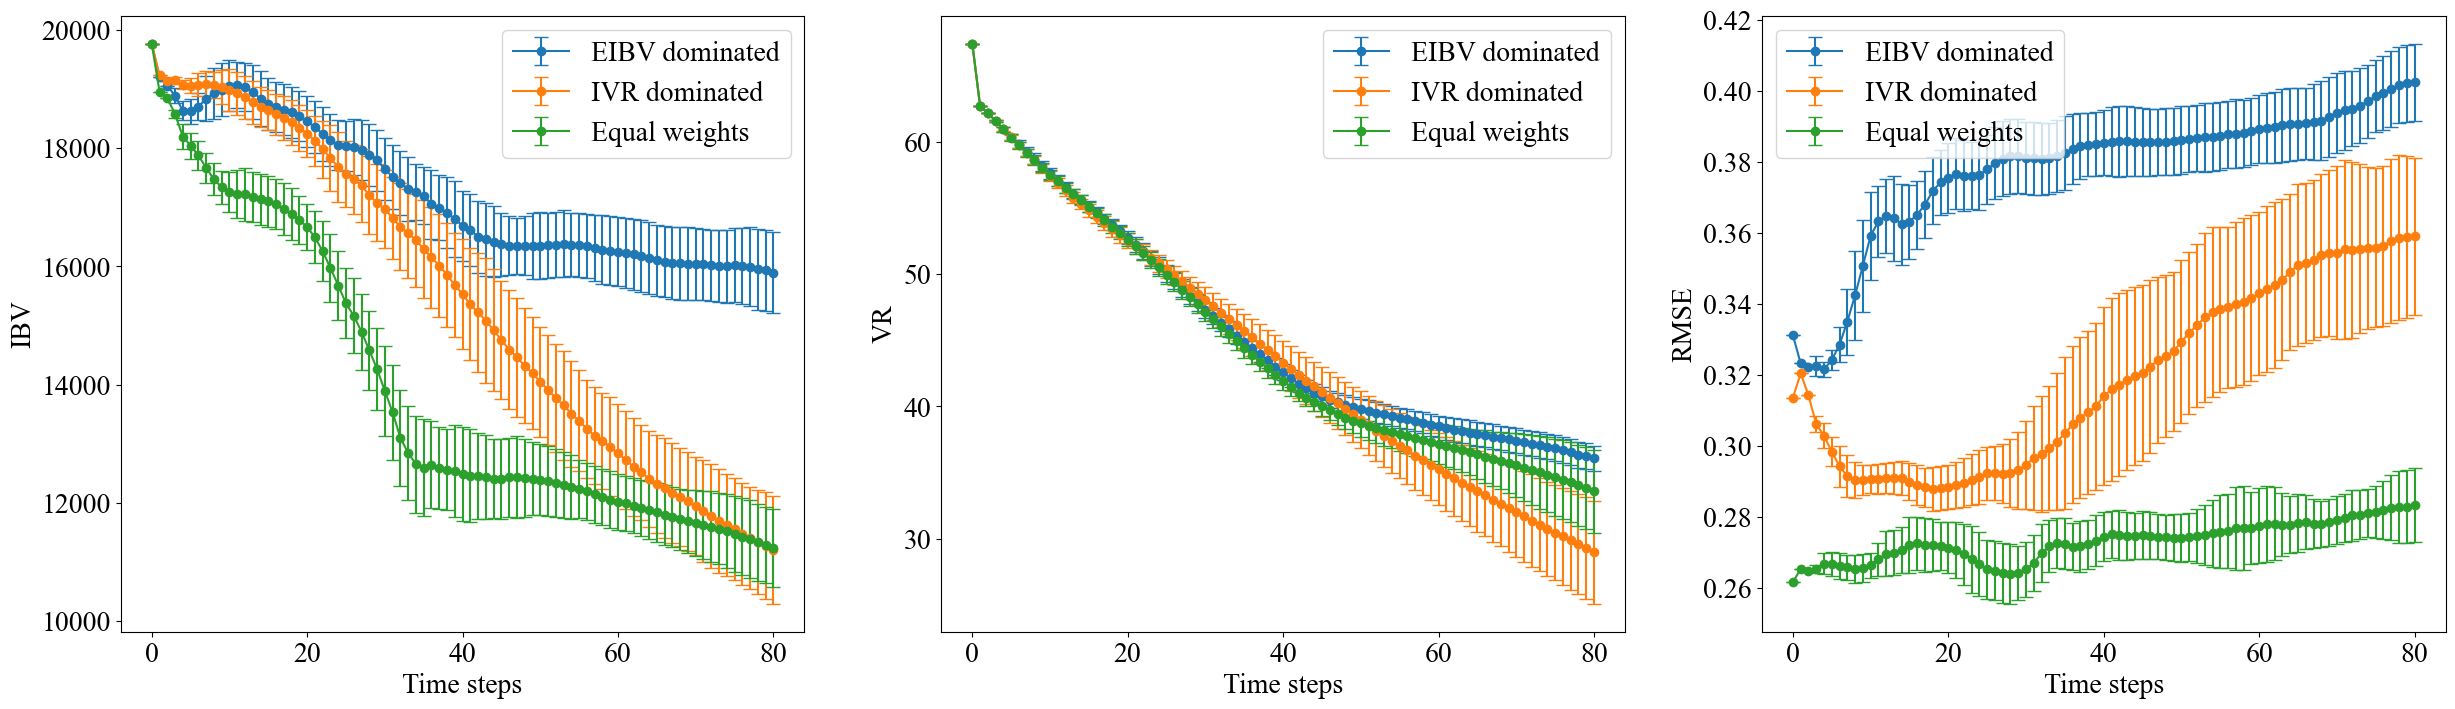

In [28]:
fig = plt.figure(figsize=(30, 8))
gs = GridSpec(nrows=1, ncols=3)
counter = 0

for metric in metrics:
    d_eibv = np.load(filepath + "../EIBV_" + metric + ".npy")
    d_ivr = np.load(filepath + "../IVR_" + metric + ".npy")
    d_eq = np.load(filepath + "../EQUAL_" + metric + ".npy")

    N = d_eibv.shape[0]
    hx = np.arange(d_eibv.shape[1])
    
    ax = fig.add_subplot(gs[counter])
    ax.errorbar(hx, y=np.mean(d_eibv, axis=0), yerr=np.std(d_eibv, axis=0), fmt="-o", capsize=5,
                         label="EIBV dominated")
    ax.errorbar(hx, y=np.mean(d_ivr, axis=0), yerr=np.std(d_ivr, axis=0), fmt="-o", capsize=5,
                         label="IVR dominated")
    ax.errorbar(hx, y=np.mean(d_eq, axis=0), yerr=np.std(d_eq, axis=0), fmt="-o", capsize=5,
                         label="Equal weights")
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel(metric.upper())

    counter += 1



# Simulation result for Myopic path planning

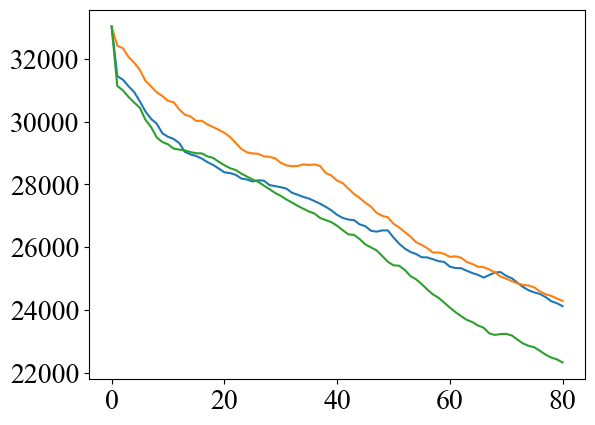

In [18]:
plt.plot(np.mean(d_ibv[:, 0, :], axis=0))
plt.plot(np.mean(d_ibv[:, 1, :], axis=0))
plt.plot(np.mean(d_ibv[:, 2, :], axis=0))


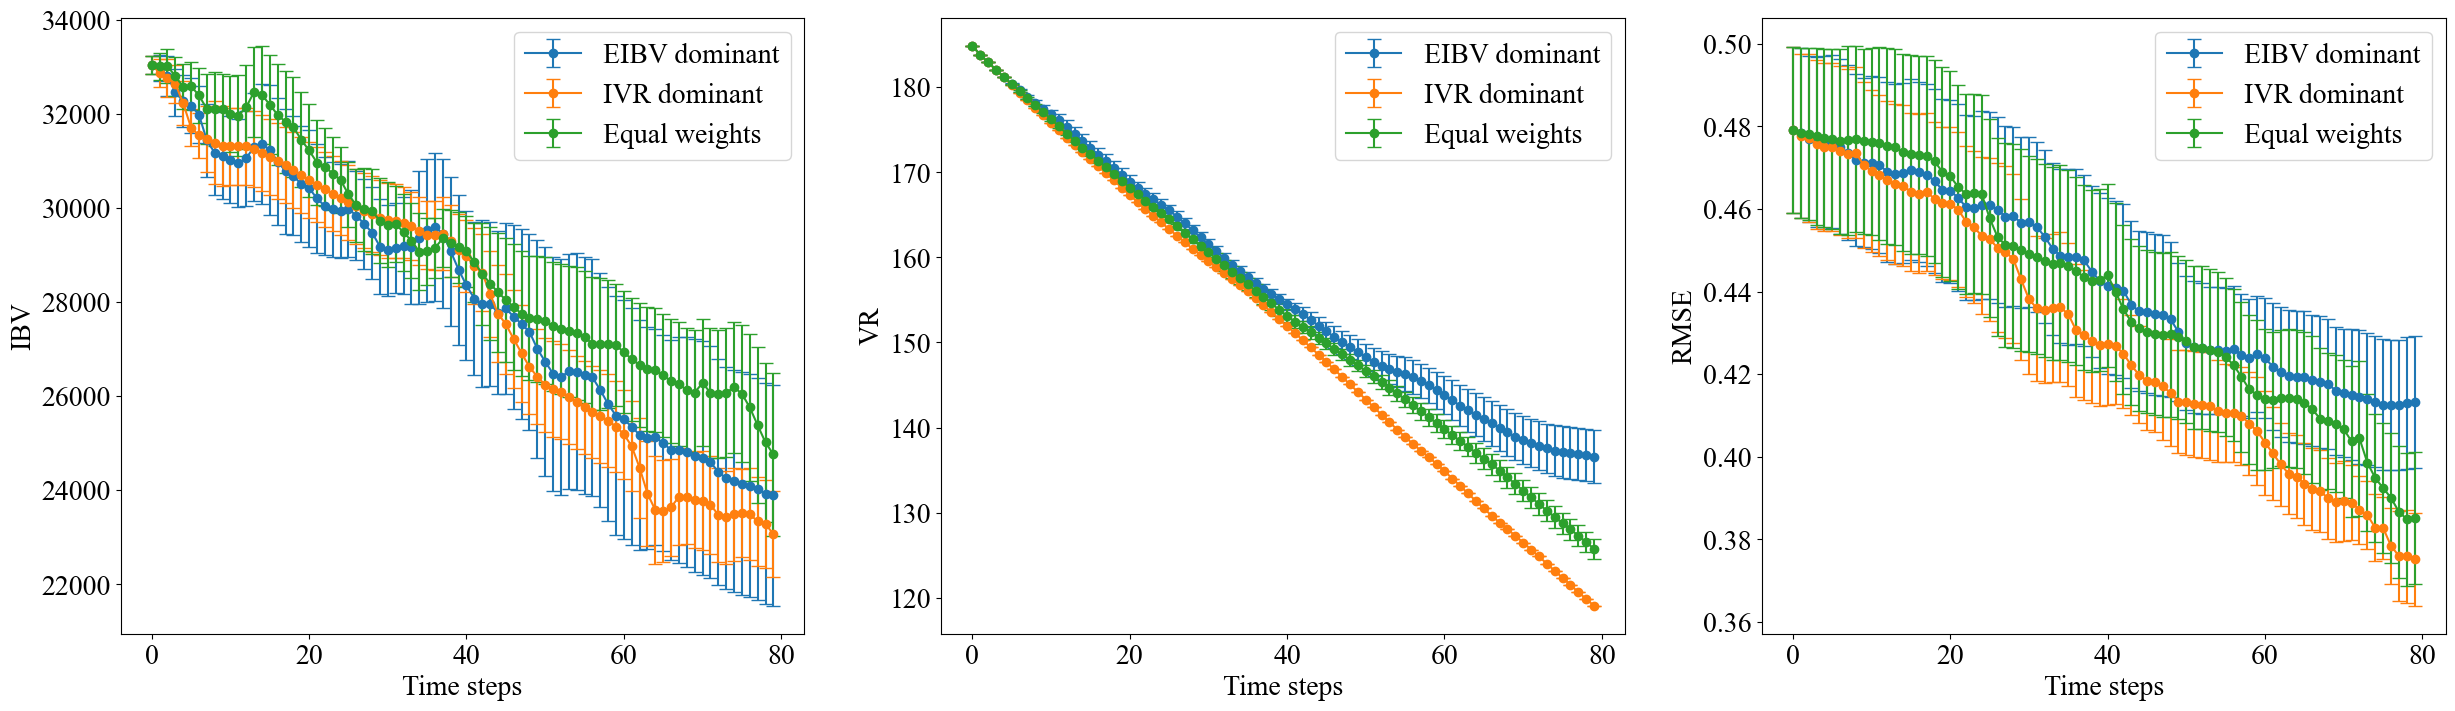

In [18]:
fig = plt.figure(figsize=(30, 8))
gs = GridSpec(nrows=1, ncols=3)

def plotf_sim(data, ylabel="IBV", counter=0):
    N = data.shape[0]
    hx = np.arange(data.shape[-1])

    ax = fig.add_subplot(gs[counter])
    ax.errorbar(hx, y=np.mean(data[:, 0, :], axis=0), yerr=np.std(data[:, 0, :], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                         label="EIBV dominant")
    ax.errorbar(hx, y=np.mean(data[:, 1, :], axis=0), yerr=np.std(data[:, 1, :], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                         label="IVR dominant")
    ax.errorbar(hx, y=np.mean(data[:, 2, :], axis=0), yerr=np.std(data[:, 2, :], axis=0)/np.sqrt(N) * 1.645, fmt="-o", capsize=5,
                         label="Equal weights")
    plt.legend()
    plt.xlabel('Time steps')
    plt.ylabel(ylabel)

plotf_sim(d_ibv, "IBV", 0)
plotf_sim(d_vr, "VR", 1)
plotf_sim(d_rmse, "RMSE", 2)

(3, 3, 5)